In [1]:
# windows only hack for graphviz path 
import os
for path in os.environ['PATH'].split(os.pathsep):
    if path.endswith("Library\\bin"):
        os.environ['PATH']+=os.pathsep+os.path.join(path, 'graphviz')

In [2]:
# 設定環境變數來控制 keras, theano
os.environ['KERAS_BACKEND']="tensorflow"
#os.environ['THEANO_FLAGS']="floatX=float32, device=cuda"

In [3]:
import keras
from keras.models import Sequential
from PIL import Image
import numpy as np

Using TensorFlow backend.


In [4]:
import keras.backend as K
# 設定 channels_first 或 channels_last
K.set_image_data_format('channels_last')

In [5]:
base_model = keras.applications.vgg16.VGG16(weights='imagenet',  include_top=False, input_shape=(64,64,3))

In [6]:
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model
_ = base_model.get_layer("block5_conv3").output
_ = GlobalAveragePooling2D()(_)
_ = Dense(512, activation='relu')(_)
# 10 個輸出
predictions = Dense(10, activation='softmax')(_)
# 這是我們的 model
model = Model(inputs=base_model.input, outputs=predictions)

# 將原來的模型設定成不可訓練，只訓練上面的兩層 dense layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
# 讀取 cifar10 dataset
# 只有 train 和 test 沒有 validation
import tarfile
import pickle
train_X=[]
train_y=[]
tar_gz = "../Week06/cifar-10-python.tar.gz"
with tarfile.open(tar_gz) as tarf:
    for i in range(1, 6):
        dataset = "cifar-10-batches-py/data_batch_%d"%i
        print("load",dataset)
        with tarf.extractfile(dataset) as f:
            result = pickle.load(f, encoding='latin1')
        train_X.extend(result['data'])
        train_y.extend(result['labels'])
    train_X=np.float32(train_X)
    train_y=np.int32(train_y)
    dataset = "cifar-10-batches-py/test_batch"
    print("load",dataset)
    with tarf.extractfile(dataset) as f:
        result = pickle.load(f, encoding='latin1')
        test_X=np.float32(result['data'])
        test_y=np.int32(result['labels'])
train_Y = np.eye(10)[train_y]
test_Y = np.eye(10)[test_y]

train_X = np.moveaxis(train_X.reshape(-1,3,32,32),1,3)
test_X = np.moveaxis(test_X.reshape(-1,3,32,32),1,3)

validation_data = (test_X[:1000], test_Y[:1000])
test_data = (test_X[1000:], test_Y[1000:])

load cifar-10-batches-py/data_batch_1
load cifar-10-batches-py/data_batch_2
load cifar-10-batches-py/data_batch_3
load cifar-10-batches-py/data_batch_4
load cifar-10-batches-py/data_batch_5
load cifar-10-batches-py/test_batch


In [8]:
# 改變輸入圖形的大小並且處理
from keras.applications.vgg16 import preprocess_input

def resize_image(arr):
    img = Image.fromarray(arr)
    img = img.resize((64,64))
    img = img.convert("RGB")
    return np.array(img)
def preprocess_X(X):
    X = X.astype('uint8')    
    X = np.float32([resize_image(X[i]) for i in range(X.shape[0])])
    return preprocess_input(X)

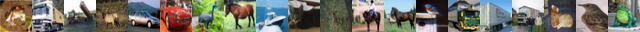

In [9]:
from PIL import Image
from IPython.display import display
def showX(X):
    int_X = X.clip(0,255).astype('uint8')
    int_X_reshape = int_X.swapaxes(0,1).reshape(32,-1,3)
    display(Image.fromarray(int_X_reshape))
# 訓練資料， X 的前 20 筆
showX(train_X[:20])

In [10]:
import numpy as np
def generate(X, Y):    
    while 1:
        idx = np.random.choice(X.shape[0], size=32, replace=False)    
        _X = preprocess_X(X[idx])
        _Y = Y[idx]
        yield (_X, _Y)
v_data = (preprocess_X(test_X[:200]), test_Y[:200])
model.fit_generator(generate(train_X, train_Y), steps_per_epoch=500, epochs=10, validation_data=v_data)

Epoch 1/10
500/500 [==============================] - 10s - loss: 1.2812 - acc: 0.7136 - val_loss: 1.0434 - val_acc: 0.7350
Epoch 2/10
500/500 [==============================] - 10s - loss: 0.6675 - acc: 0.7873 - val_loss: 0.9496 - val_acc: 0.7500
Epoch 3/10
500/500 [==============================] - 10s - loss: 0.5485 - acc: 0.8203 - val_loss: 1.0216 - val_acc: 0.6950
Epoch 4/10
500/500 [==============================] - 10s - loss: 0.5004 - acc: 0.8379 - val_loss: 0.9002 - val_acc: 0.7650
Epoch 5/10
500/500 [==============================] - 10s - loss: 0.4831 - acc: 0.8462 - val_loss: 0.9162 - val_acc: 0.7550
Epoch 6/10
500/500 [==============================] - 10s - loss: 0.4316 - acc: 0.8566 - val_loss: 0.8304 - val_acc: 0.7650
Epoch 7/10
500/500 [==============================] - 10s - loss: 0.4026 - acc: 0.8680 - val_loss: 0.9328 - val_acc: 0.7600
Epoch 8/10
500/500 [==============================] - 10s - loss: 0.3799 - acc: 0.8781 - val_loss: 0.8837 - val_acc: 0.7400
Epoch 9/

In [11]:
# 實際
predict_y = (model.predict(preprocess_X(test_X))).argmax(axis=1)
test_y = test_Y.argmax(axis=1)

In [12]:
(predict_y == test_y).mean()

0.77869999999999995

[3 8 8 8 6 6 1 6 3 1 0 9 5 7 9 6 5 7 8 6 9 0 4 9 4 5 5 6 9 6]


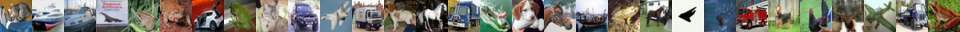

In [13]:
print(predict_y[:30])
showX(test_X[:30])

### 往前微調幾層

In [14]:
for n in ["block5_conv1", "block5_conv2", "block5_conv3"]:
    model.get_layer(n).trainable = True
from keras.optimizers import Adam
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=["accuracy"])

In [15]:
model.fit_generator(generate(train_X, train_Y), steps_per_epoch=500, epochs=10, validation_data=v_data)

Epoch 1/10
500/500 [==============================] - 16s - loss: 0.5829 - acc: 0.8099 - val_loss: 0.6786 - val_acc: 0.8150
Epoch 2/10
500/500 [==============================] - 15s - loss: 0.4286 - acc: 0.8598 - val_loss: 0.6442 - val_acc: 0.8100
Epoch 3/10
500/500 [==============================] - 15s - loss: 0.3533 - acc: 0.8844 - val_loss: 0.4610 - val_acc: 0.8650
Epoch 4/10
500/500 [==============================] - 15s - loss: 0.3121 - acc: 0.8964 - val_loss: 0.5028 - val_acc: 0.8450
Epoch 5/10
500/500 [==============================] - 15s - loss: 0.2682 - acc: 0.9101 - val_loss: 0.5108 - val_acc: 0.8500
Epoch 6/10
500/500 [==============================] - 15s - loss: 0.2464 - acc: 0.9190 - val_loss: 0.5478 - val_acc: 0.8650
Epoch 7/10
500/500 [==============================] - 15s - loss: 0.2120 - acc: 0.9298 - val_loss: 0.6227 - val_acc: 0.8500
Epoch 8/10
500/500 [==============================] - 15s - loss: 0.2056 - acc: 0.9340 - val_loss: 0.6065 - val_acc: 0.8600
Epoch 9/

In [16]:
predictions = (model.predict(preprocess_X(test_X))).argmax(axis=1)
(predictions == test_y).mean()

0.87480000000000002